# Learning to Solve Large-Scale Security-Constrained Unit Commitment Problems
Alinson S. Xavier, Feng Qiu, Shabbir Ahmed

Security-Constrained Unit Commitment (SCUC) is a fundamental problem in power systems and electricity markets. In practical settings, SCUC is repeatedly solved via Mixed-Integer Linear Programming, sometimes multiple times per day, with only minor changes in input data. In this work, we propose a number of machine learning (ML) techniques to effectively extract information from previously solved instances in order to significantly improve the computational performance of MIP solvers when solving similar instances in the future. Based on statistical data, we predict redundant constraints in the formulation, good initial feasible solutions and affine subspaces where the optimal solution is likely to lie, leading to significant reduction in problem size. Computational results on a diverse set of realistic and large-scale instances show that, using the proposed techniques, SCUC can be solved on average 12 times faster than conventional methods, with no negative impact on solution quality.

[ArXiv](https://arxiv.org/abs/1902.01697)

# Summary of complex power, impedance, and admittance

<table><tr><th> symbol </th><th> Name </th><th>Complex representation</th></tr>
    <tr><td>$Y$ </td><td> admittance  (inverse impedance) </td><td>  $Y =  G + jB$ </td></tr>
<tr><td>$B$  </td><td> susceptance  </td><td>   </td></tr>
<tr><td>$G$  </td><td>s conductance (real part of admittance) </td><td> </td></tr>
<tr><td>$Z$  </td><td> impedance  </td><td> $Z = R + jX$ </td></tr>
<tr><td>$X$  </td><td>Reactance </td><td>   </td></tr>
<tr><td>$R$  </td><td> Resistance  </td><td>  </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation from bus 1 to bus 2 in a DC model  </td><td> $S=\frac{\theta_1 - \theta_2}{-{BR}_X}$ </td></tr>
<tr><td>$S$  </td><td> Real powerflow approximation constraint  </td><td>$|S| \leq \text{Rate}_A$ </td></tr>
</table>


## Manipulating a small case

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/network/__init__.py:113: UserWarning: Unable to use graphviz, please install pygraphviz. Using networkx spring layout by default
  warnings.warn("Unable to use graphviz, please install pygraphviz. Using networkx spring layout by default")
/Users/zuck016/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


None

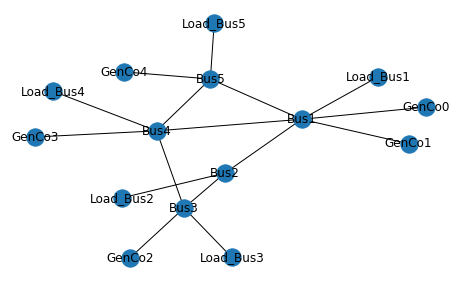

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import psst,os
from psst.case import read_matpower
from psst.model import build_model
from psst.network import create_network
casedir = 'matpower/data'
case5 = read_matpower(os.path.join(casedir,'case5.m'))
generator_df = pd.merge(case5.gen, case5.gencost, left_index=True, right_index=True)
network5 = create_network( case5, prog='neato')
display(network5.draw())
plt.savefig('case5.png')

![case5-dag](SCUC-Case5CausalModel.png)

In [38]:
case5.bus

,TYPE,PD,QD,GS,BS,AREA,VM,VA,BASEKV,ZONE,VMAX,VMIN
Bus1,2,0,0.00,0,0,1,1,0,230,1,1.1,0.9
Bus2,1,300,98.61,0,0,1,1,0,230,1,1.1,0.9
Bus3,2,300,98.61,0,0,1,1,0,230,1,1.1,0.9
Bus4,3,400,131.47,0,0,1,1,0,230,1,1.1,0.9
Bus5,2,0,0.00,0,0,1,1,0,230,1,1.1,0.9


In [37]:
case5.branch

,F_BUS,T_BUS,BR_R,BR_X,BR_B,RATE_A,RATE_B,RATE_C,TAP,SHIFT,BR_STATUS,ANGMIN,ANGMAX
0,Bus1,Bus2,0.00281,0.0281,0.00712,400,400,400,0,0,1,-360,360
1,Bus1,Bus4,0.00304,0.0304,0.00658,0,0,0,0,0,1,-360,360
2,Bus1,Bus5,0.00064,0.0064,0.03126,0,0,0,0,0,1,-360,360
3,Bus2,Bus3,0.00108,0.0108,0.01852,0,0,0,0,0,1,-360,360
4,Bus3,Bus4,0.00297,0.0297,0.00674,0,0,0,0,0,1,-360,360
5,Bus4,Bus5,0.00297,0.0297,0.00674,240,240,240,0,0,1,-360,360


In [39]:
case5.gen

,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME
GenCo0,Bus1,40.00,0,30.0,-30.0,1,100,1,40,0,0,0,0,0,0,0,0,40,0,0,0,40,40,0,0
GenCo1,Bus1,170.00,0,127.5,-127.5,1,100,1,170,0,0,0,0,0,0,0,0,170,0,0,0,170,170,0,0
GenCo2,Bus3,323.49,0,390.0,-390.0,1,100,1,520,0,0,0,0,0,0,0,0,520,0,0,0,520,520,0,0
GenCo3,Bus4,0.00,0,150.0,-150.0,1,100,1,200,0,0,0,0,0,0,0,0,200,0,0,0,200,200,0,0
GenCo4,Bus5,466.51,0,450.0,-450.0,1,100,1,600,0,0,0,0,0,0,0,0,600,0,0,0,600,600,0,0


In [40]:
case5.load

,Bus1,Bus2,Bus3,Bus4,Bus5
0,0.0,300.0,300.0,400.0,0.0


In [32]:
!. ~/.bash_profile && pyomo help --solvers


Pyomo Solvers and Solver Managers
---------------------------------
Pyomo uses 'solver managers' to execute 'solvers' that perform
optimization and other forms of model analysis.  A solver directly
executes an optimizer, typically using an executable found on the
user's PATH environment.  Solver managers support a flexible mechanism
for asyncronously executing solvers either locally or remotely.  The
following solver managers are available in Pyomo:

    neos       Asynchronously execute solvers on the NEOS server
    serial     Synchronously execute solvers locally

If no solver manager is specified, Pyomo uses the serial solver
manager to execute solvers locally.  The pyro and phpyro solver
managers require the installation and configuration of the pyro
software.  The neos solver manager is used to execute solvers on the
NEOS optimization server.


Serial Solver Interfaces
------------------------
The serial, pyro and phpyro solver managers support the following
solver interfaces:



In [2]:
import sys
#sys.path.append('/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/scipoptsuite-6.0.2/scip/interfaces/ampl/build')
try:
    model5 = build_model(case5, generator_df)
    model5.solve(solver='scip', verbose=True)
except ValueError as e:
    print(e)
    
model5.results.power_generated

Changed model.MinimumPowerOutput to use within=Reals
SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

,GenCo4,GenCo1,GenCo2,GenCo3,GenCo0
0,466.505154,170.0,323.494846,0.0,40.0


# Case 7 (with timepoints)

None

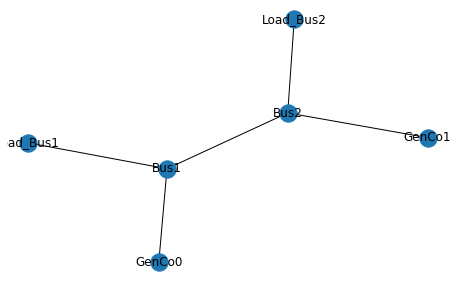

In [3]:
casedir = '../PSST/psst/docs/notebooks/cases'
case7 = read_matpower(os.path.join(casedir,'case7.m'))
generator_df = pd.merge(case7.gen, case7.gencost, left_index=True, right_index=True)
case7.load = pd.read_csv(os.path.join(casedir,'case7.csv'), index_col=0)
network7 = create_network( case7, prog='neato')
display(network7.draw())
plt.savefig('case7.png')

![SCUC-Case7CausalModel](SCUC-Case7CausalModel.png)

In [4]:
case7.load

,Bus1,Bus2
0,0.0,100.0
1,0.0,100.0
2,0.0,100.0
3,0.0,120.0
4,0.0,120.0
5,0.0,120.0
6,0.0,150.0
7,0.0,150.0
8,0.0,150.0
9,0.0,200.0


![SCUC-Case7Time](SCUC-Case7Time.png)

In [5]:
from IPython.display import HTML
HTML(generator_df[['PMIN','PMAX']].to_html().replace('\n',''))

,PMIN,PMAX
GenCo0,0,200
GenCo1,0,500


In [6]:
model7 = build_model(case7)
model7.solve(solver='scip', verbose=True)
model7.results.unit_commitment

Changed model.MinimumPowerOutput to use within=Reals
SCIP version 6.0.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 4.0.2] [GitHash: e639a0059d]
Copyright (C) 2002-2019 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External codes: 
  Readline EditLine w  GNU library for command line editing (gnu.org/s/readline)
  SoPlex 4.0.2         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: b8833cd3]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (www.coin-or.org/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  GMP 6.1.2            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.3.8          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  ASL                  AMPL Solver Library developed by D. Gay (www.netlib.com/ampl)


number of paramet

/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/solver/results.py:42: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  return df.clip_lower(0)


,GenCo1,GenCo0
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


## Which Matpower cases are readable?  Which are convertable to a UC model?

In [1]:
import sys
sys.path.append('../PSST')
import psst
from psst.case import read_matpower
from psst.network import create_network
import pandas as pd

cases = """case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte""".split('\n')

from IPython.display import display, Markdown
matpower = {}
scuc = {}
network = {}

In [2]:

import psst, os
from psst.case import read_matpower
from psst.model import build_model
casedir = 'matpower/data'
generator = {}
for casefile in cases:
    #if casefile[-2:] == '.m':
        try:
            case = read_matpower(os.path.join(casedir, casefile + '.m'))
            generator[casefile] = pd.merge(case.gen, case.gencost, left_index=True, right_index=True)
            badgen = generator[ casefile][(generator[casefile]['PMIN'] < 0)]
            if len(badgen.index) > 0:
                print('\n`{}`\n'.format(casefile))
                #print(badgen.to_html().replace('\n',''))
                display(badgen)
        except TypeError as e:
            print('Could not parse {}'.format(casefile))


`case1888rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo32,Bus973,0.0,0.0,0.0,0.0,1.039,100,0,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0



`case1951rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo35,Bus973,-7.47,0.0,0.0,0.0,1.121,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0



`case2848rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo191,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo192,Bus124,-5.91,0.0,0.0,0.0,1.047,100,1,0.0,-7.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0
GenCo314,Bus1276,-8.00,0.0,0.0,0.0,1.069,100,1,0.0,-8.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,1,0



`case3012wp`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo50,Bus152,0.0,0.00,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo51,Bus152,0.0,0.00,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo52,Bus153,0.0,0.00,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo53,Bus153,0.0,0.00,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo81,Bus240,179.0,-62.00,105,-62,1.02222,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo82,Bus240,179.0,-62.00,105,-62,1.02222,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo83,Bus240,0.0,0.00,160,-100,1.00000,209.0,0,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo84,Bus241,179.0,-19.63,160,-100,1.02222,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo192,Bus993,0.0,0.00,11,0,1.00000,24.5,0,31.0,-32.0,0,0,0,0,0,0,0,31.0,0,0,0,31.0,31.0,0,0,2,0,0,2,0,0.0,0
GenCo193,Bus993,0.0,0.00,10,0,1.00000,24.5,0,31.0,-32.0,0,0,0,0,0,0,0,31.0,0,0,0,31.0,31.0,0,0,2,0,0,2,0,0.0,0



`case3375wp`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo144,Bus152,0.0,0.0,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo145,Bus152,0.0,0.0,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo146,Bus153,0.0,0.0,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo147,Bus153,0.0,0.0,72,-29,1.00000,150.0,0,135.0,-135.0,0,0,0,0,0,0,0,135.0,0,0,0,135.0,135.0,0,0,2,0,0,2,0,137.4,0
GenCo175,Bus240,179.0,-62.0,105,-62,1.02448,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo176,Bus240,179.0,-62.0,105,-62,1.02448,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo177,Bus240,0.0,0.0,160,-100,1.00000,209.0,0,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo178,Bus241,179.0,-12.1,160,-100,1.02448,209.0,1,179.0,-200.0,0,0,0,0,0,0,0,179.0,0,0,0,179.0,179.0,0,0,2,0,0,2,0,137.4,0
GenCo286,Bus993,0.0,0.0,11,0,1.00000,24.5,0,31.0,-32.0,0,0,0,0,0,0,0,31.0,0,0,0,31.0,31.0,0,0,2,0,0,2,0,0.0,0
GenCo287,Bus993,0.0,0.0,10,0,1.00000,24.5,0,31.0,-32.0,0,0,0,0,0,0,0,31.0,0,0,0,31.0,31.0,0,0,2,0,0,2,0,0.0,0



`case6468rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo67,Bus320,0.00,0.00,0.00,0.00,1.059,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo68,Bus320,0.00,0.00,0.00,0.00,1.059,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo126,Bus626,0.00,-8.30,8.30,-8.30,1.030,100,0,8.3,-8.30,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,2,0
GenCo165,Bus752,0.00,-2.63,3.00,-3.00,0.967,100,0,5.0,-5.00,0,0,0,0,0,0,0,5.0,0,0,0,5.0,5.0,0,0,2,0,0,2,0,2,0
GenCo237,Bus1113,0.00,-1.46,50.00,-40.00,1.077,100,0,75.0,-75.00,0,0,0,0,0,0,0,75.0,0,0,0,75.0,75.0,0,0,2,0,0,2,0,2,0
GenCo238,Bus1113,0.00,27.65,50.00,-40.00,1.077,100,0,75.0,-75.00,0,0,0,0,0,0,0,75.0,0,0,0,75.0,75.0,0,0,2,0,0,2,0,2,0
GenCo393,Bus2035,13.31,7.00,7.00,-7.00,1.065,100,1,30.0,-30.00,0,0,0,0,0,0,0,30.0,0,0,0,30.0,30.0,0,0,2,0,0,2,0,1,0
GenCo425,Bus2305,0.00,8.27,20.00,-20.00,1.032,100,0,64.0,-64.00,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,2,0
GenCo551,Bus2919,0.00,0.00,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo552,Bus2919,0.00,0.00,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0



`case6470rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo67,Bus319,0.00,0.00,0.00,0.00,1.050,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo68,Bus319,0.00,0.00,0.00,0.00,1.050,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo126,Bus623,-2.11,-8.30,8.30,-8.30,1.049,100,1,8.3,-8.30,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo166,Bus750,0.00,-2.78,3.00,-3.00,0.975,100,0,5.0,-5.00,0,0,0,0,0,0,0,5.0,0,0,0,5.0,5.0,0,0,2,0,0,2,0,2,0
GenCo398,Bus2028,21.36,4.36,7.00,-7.00,1.058,100,1,30.0,-30.00,0,0,0,0,0,0,0,30.0,0,0,0,30.0,30.0,0,0,2,0,0,2,0,1,0
GenCo430,Bus2296,0.00,3.50,20.00,-20.00,1.029,100,0,64.0,-64.00,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,2,0
GenCo557,Bus2905,0.00,0.00,1.00,0.00,1.073,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo558,Bus2905,0.00,0.00,1.00,0.00,1.073,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo673,Bus3491,0.00,0.00,0.00,0.00,1.080,100,0,0.0,-8.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo701,Bus3606,12.67,8.14,30.00,-10.00,1.025,100,1,40.0,-40.00,0,0,0,0,0,0,0,40.0,0,0,0,40.0,40.0,0,0,2,0,0,2,0,1,0



`case6495rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo67,Bus317,0.00,0.00,0.00,0.00,1.064,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo68,Bus317,0.00,0.00,0.00,0.00,1.064,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo126,Bus624,-4.03,-8.30,8.30,-8.30,1.039,100,1,8.3,-8.30,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo166,Bus751,0.00,-0.18,3.00,-3.00,1.015,100,0,5.0,-5.00,0,0,0,0,0,0,0,5.0,0,0,0,5.0,5.0,0,0,2,0,0,2,0,2,0
GenCo397,Bus2022,19.35,4.07,7.00,-7.00,1.055,100,1,30.0,-30.00,0,0,0,0,0,0,0,30.0,0,0,0,30.0,30.0,0,0,2,0,0,2,0,1,0
GenCo429,Bus2290,-4.65,2.94,20.00,-20.00,1.014,100,1,64.0,-64.00,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,1,0
GenCo556,Bus2897,0.00,1.00,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo557,Bus2897,0.00,1.00,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo674,Bus3484,0.00,0.00,0.00,0.00,1.095,100,0,0.0,-8.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo699,Bus3597,10.80,1.43,30.00,-10.00,1.021,100,1,40.0,-40.00,0,0,0,0,0,0,0,40.0,0,0,0,40.0,40.0,0,0,2,0,0,2,0,1,0



`case6515rte`



,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,PMIN,PC1,PC2,QC1MIN,QC1MAX,QC2MIN,QC2MAX,RAMP_AGC,RAMP_10,RAMP_30,RAMP_Q,APF,STARTUP_RAMP,SHUTDOWN_RAMP,MINIMUM_UP_TIME,MINIMUM_DOWN_TIME,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo67,Bus317,0.00,0.00,0.00,0.00,1.058,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo68,Bus317,0.00,0.00,0.00,0.00,1.058,100,0,0.0,-7.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo126,Bus624,-4.11,-8.30,8.30,-8.30,1.047,100,1,8.3,-8.30,0,0,0,0,0,0,0,8.3,0,0,0,8.3,8.3,0,0,2,0,0,2,0,1,0
GenCo166,Bus756,0.00,-0.31,3.00,-3.00,1.020,100,0,5.0,-5.00,0,0,0,0,0,0,0,5.0,0,0,0,5.0,5.0,0,0,2,0,0,2,0,2,0
GenCo399,Bus2029,19.35,2.48,7.00,-7.00,1.041,100,1,30.0,-30.00,0,0,0,0,0,0,0,30.0,0,0,0,30.0,30.0,0,0,2,0,0,2,0,1,0
GenCo431,Bus2297,0.00,4.15,20.00,-20.00,1.015,100,0,64.0,-64.00,0,0,0,0,0,0,0,64.0,0,0,0,64.0,64.0,0,0,2,0,0,2,0,2,0
GenCo558,Bus2904,0.00,0.73,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo559,Bus2904,0.00,0.73,1.00,0.00,1.100,100,0,12.0,-10.00,0,0,0,0,0,0,0,12.0,0,0,0,12.0,12.0,0,0,2,0,0,2,0,2,0
GenCo676,Bus3491,0.00,0.00,0.00,0.00,1.100,100,0,0.0,-8.00,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0,2,0,0,2,0,2,0
GenCo701,Bus3604,11.31,3.66,30.00,-10.00,1.008,100,1,40.0,-40.00,0,0,0,0,0,0,0,40.0,0,0,0,40.0,40.0,0,0,2,0,0,2,0,1,0


## Generate Xavier 2019 Table 2

In [3]:
def set_pmin_to_zero( case ):
    """set PMIN to zero"""
    neg_pmin = case.gen['PMIN']<0
    case.gen.loc[neg_pmin,'PMIN'] = 0
    return case

def transform_neg_pmin_to_load( case ):
    """set PMIN to zero, add negative PMIN to PMAX, and add negative PMIN to load."""
    neg_pmin = case.gen['PMIN']<0
    buses = case.gen[neg_pmin][['GEN_BUS', 'PMIN']].set_index('GEN_BUS')
    case.load[buses.index] = case.load[buses.index] - buses['PMIN']
    case.gen.loc[neg_pmin,'PMAX'] = case.gen.loc[neg_pmin,'PMAX'] - case.gen.loc[neg_pmin,'PMIN']
    case.gen.loc[neg_pmin,'PMIN'] = 0
    return case

def remove_neg_gen_add_pg_to_load( case ):
    """Remove generators with PMIN < 0, and add the negative power generated (PG) to the load for that bus"""
    neg_pmin = case.gen['PMIN'] < 0
    pg = case.gen[['GEN_BUS','PG']].groupby('GEN_BUS').sum().T.reindex(case.load.columns, axis='columns').fillna(0)
    pg.index = [0]
    case.load = case.load - pg
    case.gen = case.gen[~neg_pmin]
    case.gencost = case.gencost[~neg_pmin]    
    return case
table2 = pd.DataFrame(index=cases, columns=['Buses','Units','Lines'])
table2.index.name='Instances'
for case in cases:
    print(case)
    matpower[case] = set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)))
    #scuc[case]  = build_model( matpower[case])
    table2.loc[case] = dict( Buses=len(matpower[case].bus_name),
                             Units=len(matpower[case].gen_name),
                             Lines=len(matpower[case].branch_name))
table2

case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte


,Buses,Units,Lines
Instances,,,
case1888rte,1888,298,2531
case1951rte,1951,392,2596
case2848rte,2848,548,3776
case3012wp,3012,502,3572
case3375wp,3374,596,4161
case6468rte,6468,1296,9000
case6470rte,6470,1331,9005
case6495rte,6495,1373,9019
case6515rte,6515,1389,9037


![Table2-Xavier.png](Table2-Xavier.png)

# Causal model of data generating process



| Parameter Names | Definition |  Source of Parameter values |
|------------|------------|--------------------|
| $g\in G$   | generators | given by each case |
| $b\in B$   | Buses      | given by each case |
| $\ell \in L$ | Branches (Transmission lines) | given by each case |
| $t\in [1,\ldots,T]$  | hourly time points ($T=24$) | given by each case |
| $c_g^0,c_g^1,\ldots,c^k_g,c^s_g$ | Cost of producing each additional MW of power within the piecewise interval $k$ with minimum cost $c_g^0$ and startup cost $c_g^s$ | $\alpha_gc_g^0,\alpha_gc_g^1,\ldots,\alpha_gc_g^k,\alpha_gc_g^s$ |
|$\mu_t$  | Mean of hourly load variation | Obtained from PJM January 2017 loads |
|$\sigma_t$ | Standard deviation of hourly load variation | obtained from PJM January 2017 loads|
|$d_b$ | Original per bus load percentage | `case.load.divide(case.load.sum(axis=1))` |
| $\gamma_t$ | Original hourly variation in system load $D_{t+1}/D_t$ | Obtained from PJM January 2017 loads |
| $C$ | System-wide capacity | $C = \sum_g \text{PMAX}_g$ |

| Variable | Definition |  Parametric Distribution of Random Variables |
|----------|------------|-----------------------------------|
| $\alpha_g$ | Daily change in bid prices per generator | $\alpha_g \sim  U[0.95, 1.05]$ |
| $\beta_b$  | Variation in geographical (bus) load distribution | $\beta_b  \sim  U[0.90, 1.10]$ |
| $\gamma_t'$ | Hourly variation in system load $D_{t+1}/D_t$| $\gamma_t'  \sim  N(\mu_t, \sigma_t)$ |
| $\rho$ | Peak system load ($60\% \text{ of } C = \sum_g \text{PMAX}_g) \pm 7.5\%$) | $\rho  \sim  U[0.6\times 0.92C, 0.6\times 0.1075 C]$ |

![Xavier2019](Xavier2019.png)

#  Training and Test Samples

During training 300 variations of each of the original instances were generated and solved to optimality. We considered four sources of uncertainty: 

1. uncertain production and startup costs; 
2. uncertain geographical load distribution; 
3. uncertain peak system load; and 
4. uncertain temporal load profile. 

The precise randomization scheme is described below. The specific parameters were chosen based on our analysis of publicly available bid and hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx), corresponding to the month of January, 2017. 

1. **Production and startup costs**. In the original instances, the production cost for each generator $g\in G$ is modelled as a convex piecewise-linear function described by the parameters $c^0_g$, the cost of producing the minimum amount of power, and $c^1_g,\ldots ,c^k_g$, the costs of producing each additional MW of power within the piecewise interval $k$. In addition, each generator has a startup cost $c^s_g$. In our data analysis, we observed that the daily changes in bid prices rarely exceeded $\pm 5\%$. Therefore, random numbers $\alpha_g$ were independently drawn from the uniform distribution in the interval $\left[0.95,1.05\right]$, for each generator $g\in G$, and the costs of $g$ were linearly scaled by this factor. That is, the costs for generator $g$ were set to $\alpha_g c^0_g, \alpha_g c^1_g, \ldots  \alpha_g c^k_g, \alpha_g c^s_g$. 

In [4]:
import numpy as np
np.random.seed(20191120)
def get_production_and_startup_costs( case, low=0.95, high=1.05 ):
    alpha = np.random.uniform(low=low, high=high, size=len(case.gen_name))
    cols = ['STARTUP'] + ['COST_{}'.format(k) for k in range(case.gencost.loc['GenCo0', 'NCOST'] + 1)]
    gencost = case.gencost.copy()
    gencost[cols] = gencost[cols].multiply(alpha, axis=0)
    return gencost
get_production_and_startup_costs(matpower[case] ).head()

,MODEL,STARTUP,SHUTDOWN,NCOST,COST_2,COST_1,COST_0
GenCo0,2,0.0,0,2,0.0,2.098991,0.0
GenCo1,2,0.0,0,2,0.0,1.905209,0.0
GenCo2,2,0.0,0,2,0.0,1.918524,0.0
GenCo3,2,0.0,0,2,0.0,1.035478,0.0
GenCo4,2,0.0,0,2,0.0,2.039641,0.0


2. **Geographical load distribution**. In the original instances, each bus $b\in B$ is responsible for a certain percentage $d_b$ of the total system load. To generate variations of these parameters, random numbers $\beta_b$ were independently drawn from the uniform distribution in the interval $\left[0.90, 1.10\right]$. The percentages $d_b$ were then linearly scaled by the $\beta$ factors and later normalized. More precisely, the demand for each bus $b\in B$ was set to $\frac{\beta_b d_b}{\sum_{i\in b} \beta_i}$.

Note that the normalization constant described above is incorrect. It should be:

$$\frac{\beta_b d_b}{\sum_{i\in b} \beta_i d_i}$$


In [5]:
def get_geographical_load_distribution( case, low=0.9, high=1.1 ):
    """"""
    beta= np.random.uniform(low=low, high=high, size=len(case.bus_name))
    load_distribution = case.load.multiply(beta, axis=1)
    normalized_load_distribution = load_distribution/np.squeeze(load_distribution.sum(axis=1))
    return normalized_load_distribution
total_load = np.squeeze(matpower[case].load.sum(axis=1))
get_geographical_load_distribution( matpower[case] )*total_load

,Bus1,Bus2,Bus3,Bus4,Bus5,Bus6,Bus7,Bus8,Bus9,Bus10,Bus11,Bus12,Bus13,Bus14,Bus15,Bus16,Bus17,Bus18,Bus19,Bus20,Bus21,Bus22,Bus23,Bus24,Bus25,Bus26,Bus27,Bus28,Bus29,Bus30,Bus31,Bus32,Bus33,Bus34,Bus35,Bus36,Bus37,Bus38,Bus39,Bus40,Bus41,Bus42,Bus43,Bus44,Bus45,Bus46,Bus47,Bus48,Bus49,Bus50,Bus51,Bus52,Bus53,Bus54,Bus55,Bus56,Bus57,Bus58,Bus59,Bus60,Bus61,Bus62,Bus63,Bus64,Bus65,Bus66,Bus67,Bus68,Bus69,Bus70,Bus71,Bus72,Bus73,Bus74,Bus75,Bus76,Bus77,Bus78,Bus79,Bus80,Bus81,Bus82,Bus83,Bus84,Bus85,Bus86,Bus87,Bus88,Bus89,Bus90,Bus91,Bus92,Bus93,Bus94,Bus95,Bus96,Bus97,Bus98,Bus99,Bus100,Bus101,Bus102,Bus103,Bus104,Bus105,Bus106,Bus107,Bus108,Bus109,Bus110,Bus111,Bus112,Bus113,Bus114,Bus115,Bus116,Bus117,Bus118,Bus119,Bus120,Bus121,Bus122,Bus123,Bus124,Bus125,Bus126,Bus127,Bus128,Bus129,Bus130,Bus131,Bus132,Bus133,Bus134,Bus135,Bus136,Bus137,Bus138,Bus139,Bus140,Bus141,Bus142,Bus143,Bus144,Bus145,Bus146,Bus147,Bus148,Bus149,Bus150,Bus151,Bus152,Bus153,Bus154,Bus155,Bus156,Bus157,Bus158,Bus159,Bus160,Bus161,Bus162,Bus163,Bus164,Bus165,Bus166,Bus167,Bus168,Bus169,Bus170,Bus171,Bus172,Bus173,Bus174,Bus175,Bus176,Bus177,Bus178,Bus179,Bus180,Bus181,Bus182,Bus183,Bus184,Bus185,Bus186,Bus187,Bus188,Bus189,Bus190,Bus191,Bus192,Bus193,Bus194,Bus195,Bus196,Bus197,Bus198,Bus199,Bus200,Bus201,Bus202,Bus203,Bus204,Bus205,Bus206,Bus207,Bus208,Bus209,Bus210,Bus211,Bus212,Bus213,Bus214,Bus215,Bus216,Bus217,Bus218,Bus219,Bus220,Bus221,Bus222,Bus223,Bus224,Bus225,Bus226,Bus227,Bus228,Bus229,Bus230,Bus231,Bus232,Bus233,Bus234,Bus235,Bus236,Bus237,Bus238,Bus239,Bus240,Bus241,Bus242,Bus243,Bus244,Bus245,Bus246,Bus247,Bus248,Bus249,Bus250,Bus251,Bus252,Bus253,Bus254,Bus255,Bus256,Bus257,Bus258,Bus259,Bus260,Bus261,Bus262,Bus263,Bus264,Bus265,Bus266,Bus267,Bus268,Bus269,Bus270,Bus271,Bus272,Bus273,Bus274,Bus275,Bus276,Bus277,Bus278,Bus279,Bus280,Bus281,Bus282,Bus283,Bus284,Bus285,Bus286,Bus287,Bus288,Bus289,Bus290,Bus291,Bus292,Bus293,Bus294,Bus295,Bus296,Bus297,Bus298,Bus299,Bus300,Bus301,Bus302,Bus303,Bus304,Bus305,Bus306,Bus307,Bus308,Bus309,Bus310,Bus311,Bus312,Bus313,Bus314,Bus315,Bus316,Bus317,Bus318,Bus319,Bus320,Bus321,Bus322,Bus323,Bus324,Bus325,Bus326,Bus327,Bus328,Bus329,Bus330,Bus331,Bus332,Bus333,Bus334,Bus335,Bus336,Bus337,Bus338,Bus339,Bus340,Bus341,Bus342,Bus343,Bus344,Bus345,Bus346,Bus347,Bus348,Bus349,Bus350,Bus351,Bus352,Bus353,Bus354,Bus355,Bus356,Bus357,Bus358,Bus359,Bus360,Bus361,Bus362,Bus363,Bus364,Bus365,Bus366,Bus367,Bus368,Bus369,Bus370,Bus371,Bus372,Bus373,Bus374,Bus375,Bus376,Bus377,Bus378,Bus379,Bus380,Bus381,Bus382,Bus383,Bus384,Bus385,Bus386,Bus387,Bus388,Bus389,Bus390,Bus391,Bus392,Bus393,Bus394,Bus395,Bus396,Bus397,Bus398,Bus399,Bus400,Bus401,Bus402,Bus403,Bus404,Bus405,Bus406,Bus407,Bus408,Bus409,Bus410,Bus411,Bus412,Bus413,Bus414,Bus415,Bus416,Bus417,Bus418,Bus419,Bus420,Bus421,Bus422,Bus423,Bus424,Bus425,Bus426,Bus427,Bus428,Bus429,Bus430,Bus431,Bus432,Bus433,Bus434,Bus435,Bus436,Bus437,Bus438,Bus439,Bus440,Bus441,Bus442,Bus443,Bus444,Bus445,Bus446,Bus447,Bus448,Bus449,Bus450,Bus451,Bus452,Bus453,Bus454,Bus455,Bus456,Bus457,Bus458,Bus459,Bus460,Bus461,Bus462,Bus463,Bus464,Bus465,Bus466,Bus467,Bus468,Bus469,Bus470,Bus471,Bus472,Bus473,Bus474,Bus475,Bus476,Bus477,Bus478,Bus479,Bus480,Bus481,Bus482,Bus483,Bus484,Bus485,Bus486,Bus487,Bus488,Bus489,Bus490,Bus491,Bus492,Bus493,Bus494,Bus495,Bus496,Bus497,Bus498,Bus499,...,Bus6017,Bus6018,Bus6019,Bus6020,Bus6021,Bus6022,Bus6023,Bus6024,Bus6025,Bus6026,Bus6027,Bus6028,Bus6029,Bus6030,Bus6031,Bus6032,Bus6033,Bus6034,Bus6035,Bus6036,Bus6037,Bus6038,Bus6039,Bus6040,Bus6041,Bus6042,Bus6043,Bus6044,Bus6045,Bus6046,Bus6047,Bus6048,Bus6049,Bus6050,Bus6051,Bus6052,Bus6053,Bus6054,Bus6055,Bus6056,Bus6057,Bus6058,Bus6059,Bus6060,Bus6061,Bus6062,Bus6063,Bus6064,Bus6065,Bus6066,Bus6067,Bus6068,Bus6069,Bus6070,Bus6071,Bus6072,Bus6073,Bus6074,Bus6075,Bus6076,Bus6077,Bus6078,Bus6079,Bus6080,Bus6081,Bus6082,Bus6083,Bus6084,Bus6085,Bus6086,Bus6087,Bus6088,Bus6089,Bus6090,Bus6091,Bus6092,Bu

In [6]:
geo_load = pd.DataFrame()
for i in range(10):
    geo_load[i] = get_geographical_load_distribution( matpower[case] ).loc[0]


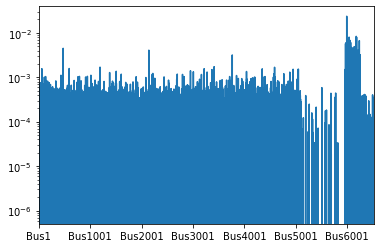

In [9]:
geo_load[i].plot(legend=False)
plt.yscale('log')
plt.show()

3. **Peak system load and temporal load profile.** For simplicity, assume $T=\left\{1,\ldots,24\right\}$. Let
$D_1, \ldots ,D_{24}$ denote the system-wide load during each hour of operation, and let $\gamma_t=\frac{D_{t+1}}{D_t}$ for $t= 1,\ldots , 23$, be the hourly variation in system load. In order to generate realistic distribution for these parameters, we analyzed hourly demand data from [PJM (2018)](https://www.pjm.com/markets-and-operations/energy.aspx). More specifically, we computed the mean $\mu_t$ and variance
$\sigma^2_t$ of each parameter $\gamma_t$, for $t= 1,\ldots ,23$.

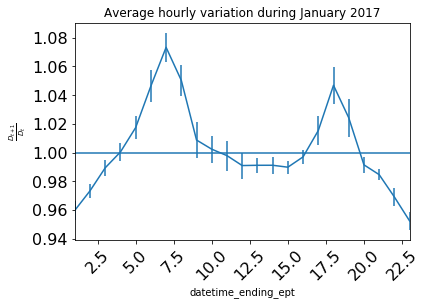

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
hrl = pd.read_csv('hrl_load_estimated.csv',infer_datetime_format=True, parse_dates=['datetime_beginning_utc', 
                                                                                    'datetime_beginning_ept',
                                                                                    'datetime_ending_utc', 
                                                                                    'datetime_ending_ept',])
gamma = hrl.groupby(['load_area',hrl['datetime_ending_ept'].dt.hour]).mean().unstack(0).pct_change() + 1
hourly_variation = gamma.mean(axis=1).dropna().to_frame('$\mu$')
hourly_variation['$\sigma$'] = gamma.std(axis=1).dropna()
hourly_variation['$\mu$'].plot(legend=False,
                               #xticks=hourly_variation.index,
                               kind="line",
                               rot=45,
                               fontsize=16,
                               yerr=hourly_variation['$\sigma$'])
plt.ylabel(r'$\frac{D_{t+1}}{D_t}$')
plt.title(r'Average hourly variation during January 2017')
plt.axhline(y=1)


 To generate instance variations, random numbers
 ${\gamma'}_t$ were then independently drawn from the Gaussian distribution $N(\mu_t, \sigma^2_t)$. Note that the
 $\gamma'$ parameters only specify the variation in system load from hour to hour, and are not sufficient to determine
 $D_1,\ldots ,D_{24}$. Therefore, in addition to these parameters, a random number $\rho$, corresponding to the peak system load $\max\{D_1,\ldots D_{24}\}$, was also generated. In the original instances, the peak system load is always $60\%$ of the total capacity. Based on our data analysis, we observed that the actual peak load rarely deviates more than $\pm 7.5\%$ from the day-ahead forecast. Therefore, to generate instance variations,$\rho$ was sampled from the uniform distribution in the interval $\left[0.6 \times 0.925C, 0.6\times 1.075C\right]$, where $C$ is the total capacity. Note that the $\rho$ and $\gamma'$ are now sufficient to construct $D_1,\ldots D_{24}$. Figure 1 shows a sample of some artificially generated load profiles.
 

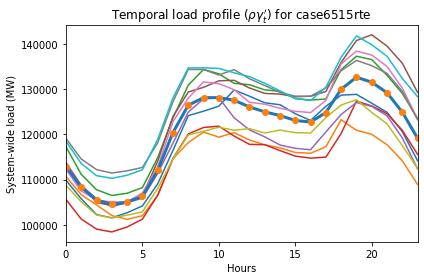

In [14]:
def get_peak_system_load( case,  capacity_pct=0.6, deviation=0.075 ):
    capacity = case.gen['PMAX'].sum()
    rho = np.random.uniform( low = capacity_pct*(1-deviation)*capacity, 
                            high = capacity_pct*(1+deviation)*capacity
                            )
    return rho
def get_hourly_load( case, hourly_variation_mean, hourly_variation_std ):
    gamma = np.random.normal(loc= hourly_variation_mean,
                            scale= hourly_variation_std)
    return gamma

def get_temporal_load_profile( case, gamma_prime, rho ):
    system_wide_load = [rho] + [0 for i in range(23)]
    t = 0
    for g_t in gamma_prime:
        system_wide_load[t+1] = system_wide_load[t]*g_t
        t += 1
    return system_wide_load

system_wide_load = pd.DataFrame()
for i in range(10):
    rho = get_peak_system_load( matpower[case] )
    gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
    system_wide_load[i] = get_temporal_load_profile( matpower[case], gamma, rho)
system_wide_load.plot(legend=False)
system_wide_load.mean(axis=1).plot(linewidth=3)
system_wide_load.mean(axis=1).plot(style='o')
plt.title(r"Temporal load profile ($\rho\gamma_t'$) for {}".format(matpower[case].name))
plt.xlabel('Hours')
plt.ylabel('System-wide load (MW)')
plt.tight_layout()
plt.savefig('duck-profiles.png')
plt.show()

In [16]:
def get_bus_loads( case, gamma, rho, T=24 ):
    
    geo_load = get_geographical_load_distribution( case )
    bus_load = pd.DataFrame(columns=geo_load.columns, index=[t for t in range(T)])
    for t, gamma_t in enumerate(get_temporal_load_profile( case, gamma, rho)):
        bus_load.loc[t] = geo_load.loc[0]*gamma_t
    return bus_load

rho = get_peak_system_load( matpower[case] )
gamma = get_hourly_load( matpower[case], hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
bus_load = get_bus_loads( matpower[case], gamma, rho )
bus_load.to_csv('{}_instance_{}.csv'.format(case, 0))
bus_load



Bus1 Bus2     Bus3 Bus4     Bus5     Bus6 Bus7 Bus8 Bus9    Bus10  \
0   5.83148    0  128.924    0  31.2275  40.4791    0    0    0  148.817   
1   5.60689    0  123.959    0  30.0249  38.9201    0    0    0  143.085   
2   5.46837    0  120.896    0  29.2831  37.9586    0    0    0   139.55   
3   5.40468    0  119.488    0   28.942  37.5165    0    0    0  137.925   
4   5.36412    0  118.591    0  28.7248  37.2349    0    0    0   136.89   
5   5.48869    0  121.345    0  29.3919  38.0996    0    0    0  140.069   
6   5.72492    0  126.568    0  30.6569  39.7394    0    0    0  146.097   
7    6.1441    0  135.835    0  32.9016  42.6491    0    0    0  156.794   
8   6.39401    0   141.36    0  34.2399  44.3838    0    0    0  163.172   
9   6.50798    0   143.88    0  34.8502   45.175    0    0    0   166.08   
10  6.54793    0  144.763    0  35.0641  45.4523    0    0    0    167.1   
11  6.49056    0  143.495    0  34.7569  45.0541    0    0    0  165.636   
12  6.32573    0  139.851    0  33.8743  43.9099    0    0    0   161.43   
13   6.3079    0  139.457    0  33.7788  43.7862    0    0    0  160.975   
14  6.17521    0  136.523    0  33.0682  42.8651    0    0    0  157.588   
15  6.11323    0  135.153    0  32.7363  42.4349    0    0    0  156.007   
16  6.10026    0  134.866    0  32.6669  42.3448    0    0    0  155.676   
17  6.11853    0   135.27    0  32.7647  42.4716    0    0    0  156.142   
18  6.41969    0  141.928    0  34.3774  44.5621    0    0    0  163.827   
19  6.65805    0  147.198    0  35.6538  46.2167    0    0    0   169.91   
20  6.58459    0  145.574    0  35.2604  45.7068    0    0    0  168.036   
21    6.456    0  142.731    0  34.5718  44.8142    0    0    0  164.754   
22  6.24981    0  138.172    0  33.4677  43.3829    0    0    0  159.492   
23  6.04991    0  133.753    0  32.3972  41.9953    0    0    0  154.391   

      Bus11    Bus12    Bus13    Bus14 Bus15 Bus16    Bus17    Bus18    Bus19  \
0   22.0761   39.172  64.6791  36.0486     0     0  21.0595  5.92157  33.2873   
1   21.2258  37.6634   62.188  34.6603     0     0  20.2484  5.69351  32.0053   
2   20.7014  36.7329  60.6517   33.804     0     0  19.7482  5.55285  31.2146   
3   20.4603  36.3051  59.9453  33.4103     0     0  19.5182  5.48818  30.8511   
4   20.3068  36.0326  59.4953  33.1595     0     0  19.3717  5.44698  30.6195   
5   20.7784  36.8694   60.877  33.9296     0     0  19.8215  5.57348  31.3306   
6   21.6726  38.4562  63.4971  35.3899     0     0  20.6746  5.81335   32.679   
7   23.2595   41.272  68.1464  37.9811     0     0  22.1884  6.23901  35.0718   
8   24.2056  42.9507  70.9182   39.526     0     0  23.0909  6.49278  36.4983   
9   24.6371  43.7163  72.1823  40.2306     0     0  23.5025  6.60851  37.1489   
10  24.7883  43.9847  72.6254  40.4775     0     0  23.6468  6.64908   37.377   
11  24.5711  43.5993  71.9892  40.1229     0     0  23.4396  6.59083  37.0495   
12  23.9471  42.4921   70.161   39.104     0     0  22.8444  6.42345  36.1086   
13  23.8796  42.3723  69.9632  38.9937     0     0    22.78  6.40535  36.0068   
14  23.3773   41.481  68.4915  38.1735     0     0  22.3008  6.27061  35.2494   
15  23.1427  41.0647  67.8041  37.7903     0     0   22.077  6.20767  34.8956   
16  23.0936  40.9775  67.6602  37.7102     0     0  22.0301   6.1945  34.8216   
17  23.1627  41.1002  67.8628  37.8231     0     0  22.0961  6.21304  34.9258   
18  24.3028  43.1232  71.2031  39.6848     0     0  23.1837  6.51886  36.6449   
19  25.2052  44.7244  73.8469  41.1583     0     0  24.0445  6.76091  38.0056   
20  24.9271  44.2309  73.0321  40.7042     0     0  23.7792  6.68631  37.5862   
21  24.4403  43.3671  71.6058  39.9092     0     0  23.3148  6.55573  36.8522   
22  23.6597  41.9821  69.3189  38.6346     0     0  22.5702  6.34635  35.6752   
23   22.903  40.6393  67.1017  37.3989     0     0  21.8483  6.14337  34.5341   

      Bus20    Bus21    Bus22    Bus23    Bus25    Bus27    Bus28 Bus29 Bus30  \

# Generated loads and costs for all Xavier cases

In [17]:
def generate_instance_of_case( case, hourly_variation ):
    generator_cost = get_production_and_startup_costs( case )
    rho = get_peak_system_load( case )
    gamma = get_hourly_load( case, hourly_variation[r'$\mu$'], hourly_variation[r'$\sigma$'] )
    bus_load = get_bus_loads( case, gamma, rho )
    return generator_cost, bus_load

for case in cases:
    os.makedirs(case,exist_ok=True)
    matpower[case] =  set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)) )
    print(case)
    #display(matpower[case].load)
    for i in range(3):
        generator_cost, bus_load = generate_instance_of_case( matpower[case], hourly_variation )
        bus_load.to_csv('{}/{}_load_{:03d}.csv'.format(case, case, i))
        generator_cost.to_csv('{}/{}_gencost_{:03d}.csv'.format(case, case, i))

    

case1888rte
case1951rte
case2848rte
case3012wp
case3375wp
case6468rte
case6470rte
case6495rte
case6515rte


During test, 50 additional variations of each original instance were generated, using the same randomization scheme outline above, but with a different random seed. These instances were then solved to optimality using four different strategies: without any machine-learning $\bf\tt{(zero)}$, using only the transmission oracle $\tt{(tr)}$, using transmission and warm-start oracles $\tt{(tr-ws)}$ and finally using only the transmission and affine subspace detection oracles $\tt{(tr-aff)}$. For strategies $\tt{zero}$, $\tt{tr}$ and $\tt{tr-ws}$, CPLEX was configured to use a relative MIP gap tolerance of $0.1\%$. For strategy $\tt{tr-aff}$, this tolerance was reduced to $0.05\%$, to compensate for eventual inaccurate predictions.

## Remove transmission line security constraint and see if it is violated in the SCUC solution.

In [18]:
def get_violated_line_constraints( case, initial_tlc, solver='scip', verbose=False ):
    """Compare scuc line power result with initial transmission line constraints. Return which transmission lines were violated"""
    scuc = build_model(case)
    scuc.solve(verbose=verbose, solver=solver)
    vlc = initial_tlc - scuc.results.line_power.abs()
    return vlc[vlc < 0].dropna(axis=1).columns, scuc

def iteratively_apply_transmission_line_constraints( case, tlc ='RATE_A', solver='scip', verbose=False):
    """Unconstrain all transmission lines, solve, and iteratively reinstate those constraints that were violated in the previous solution util no more violations
    case: psst matpower case
    tlc: Transmission line constraint name
    solver:  PYOMO MILP solver name
    verbose:  PYOMO solver output verbosity
    """
    i = 0
    scuc, violated_line_constraints = {},{}
    initial_branch = case.branch.copy()
    # Matpower uses the convention that transmission line constraints==0 are considered infinite, so we make it explicit
    zero_tlc = initial_branch[tlc] == 0
    initial_branch.loc[zero_tlc,tlc] = np.Inf
    # Sanity check to see if original problem has violated line constraints 
    violated_line_constraints[i], scuc[i] =  get_violated_line_constraints( case, initial_branch[tlc], solver=solver, verbose=verbose) 
    if len( violated_line_constraints[i] ) > 0:
        raise Error("Original solution contains violated line constraints")
    elif verbose:
        print('Completed iteration {}. Number of violated constraints: {}'.format(i, len(violated_line_constraints[i])))
    # Unconstrain all transmission lines and only add back in which ones were violated.
    case.branch[tlc] = 0
    while True:
        i+=1
        violated_line_constraints[i], scuc[i] = get_violated_line_constraints( case, initial_branch[tlc], solver=solver,verbose=verbose)
        # Reinstate the initial line constraints for all violated line constraints in the next iteration
        case.branch.loc[violated_line_constraints[i],tlc] = initial_branch.loc[violated_line_constraints[i],tlc]
        if verbose:
            print('Completed iteration {}. Number of violated constraints: {}'.format(i, len(violated_line_constraints[i])))
        if len(violated_line_constraints[i]) == 0:
            break
    return scuc, violated_line_constraints

In [19]:
branches = {}
line_power = {}
matpower = {}
for case in ['case1888rte']:
    matpower[case] =  set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)) )
    print('case {}:\n\tBuses: {}\n\tUnits: {}\n\tLines: {}\n'.format(case, len(matpower[case].bus_name), len(matpower[case].gen_name), 
                                                                     len(matpower[case].branch_name)))
    generator_cost, bus_load = generate_instance_of_case( matpower[case], hourly_variation )
    matpower[case].gencost = generator_cost
    matpower[case].load= bus_load
    scuc, vlc = iteratively_apply_transmission_line_constraints( matpower[case], 'RATE_A', 'gurobi', verbose=True )
    print("set of violated line constraints")
    violated_line_constraints = set()
    for i in range(len(vlc)):
        print('Number of violated line constraints in iteration {}: {}'.format(i, len(vlc[i])))
    

case case1888rte:
	Buses: 1888
	Units: 298
	Lines: 2531



/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
Using license file /Users/zuck016/gurobi.lic
Read LP format model from file /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpipy8m25n.pyomo.lp
Reading time = 1.80 seconds
TotalCostObjective: 393087 rows, 344873 columns, 1126311 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 393087 rows, 344873 columns and 1126311 nonzeros
Model fingerprint: 0xd7ecdc1e
Variable types: 337721 continuous, 7152 integer (7152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-02, 2e+03]
  RHS range        [1e-02, 7e+04]
Presolve removed 309183 rows and 224213 columns
Presolve time: 1.73s
Presolved: 83904 rows, 120660 columns, 292786 nonzeros
Variable types: 113580 continuous, 7080 integer (7080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
Using license file /Users/zuck016/gurobi.lic
Read LP format model from file /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmph44mekoi.pyomo.lp
Reading time = 1.62 seconds
TotalCostObjective: 293439 rows, 344873 columns, 1026663 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 293439 rows, 344873 columns and 1026663 nonzeros
Model fingerprint: 0x8d6ee1bc
Variable types: 337721 continuous, 7152 integer (7152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-02, 2e+03]
  RHS range        [1e-02, 7e+04]
Presolve removed 221635 rows and 229745 columns
Presolve time: 1.38s
Presolved: 71804 rows, 115128 columns, 267618 nonzeros
Variable types: 108048 continuous, 7080 integer (7080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
Using license file /Users/zuck016/gurobi.lic
Read LP format model from file /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmp9fqoe_41.pyomo.lp
Reading time = 1.57 seconds
TotalCostObjective: 294783 rows, 344873 columns, 1028007 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 294783 rows, 344873 columns and 1028007 nonzeros
Model fingerprint: 0x8eddcf04
Variable types: 337721 continuous, 7152 integer (7152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-02, 2e+03]
  RHS range        [1e-02, 7e+04]
Presolve removed 222307 rows and 229073 columns
Presolve time: 1.39s
Presolved: 72476 rows, 115800 columns, 269082 nonzeros
Variable types: 108720 continuous, 7080 integer (7080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
Using license file /Users/zuck016/gurobi.lic
Read LP format model from file /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpzrgeca24.pyomo.lp
Reading time = 1.58 seconds
TotalCostObjective: 294975 rows, 344873 columns, 1028199 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 294975 rows, 344873 columns and 1028199 nonzeros
Model fingerprint: 0xec775b5c
Variable types: 337721 continuous, 7152 integer (7152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-02, 2e+03]
  RHS range        [1e-02, 7e+04]
Presolve removed 222403 rows and 228977 columns
Presolve time: 1.36s
Presolved: 72572 rows, 115896 columns, 269322 nonzeros
Variable types: 108816 continuous, 7080 integer (7080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex


/Users/zuck016/Projects/Proposals/DataModelConvergence_2019/PSST/psst/psst/model/__init__.py:85: UserWarning: Generators with zero PMAX found: ['GenCo32']
  warnings.warn("Generators with zero PMAX found: {}".format(zero_generation))


Changed model.MinimumPowerOutput to use within=Reals
Using license file /Users/zuck016/gurobi.lic
Read LP format model from file /var/folders/z1/nhct2gps3y94tkbwqvvd7y_jw6p1l8/T/tmpi379txtb.pyomo.lp
Reading time = 1.64 seconds
TotalCostObjective: 295023 rows, 344873 columns, 1028247 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 295023 rows, 344873 columns and 1028247 nonzeros
Model fingerprint: 0x517fcbe4
Variable types: 337721 continuous, 7152 integer (7152 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-02, 2e+03]
  RHS range        [1e-02, 7e+04]
Presolve removed 222427 rows and 228953 columns
Presolve time: 1.51s
Presolved: 72596 rows, 115920 columns, 269370 nonzeros
Variable types: 108840 continuous, 7080 integer (7080 binary)

Deterministic concurrent LP optimizer: primal and dual simplex


# Power Transfer Distribution Factors (PTDF)

In [49]:
from psst.case.utils import calculate_PTDF
matpower[case] =  set_pmin_to_zero( read_matpower('matpower/data/{}.m'.format(case)) )

ptdf = calculate_PTDF(matpower[case])
ptdf

makePTDF: buses must be numbered consecutivelymakeBdc: buses must be numbered consecutively in bus matrix


ValueError: column index exceeds matrix dimensions

In [50]:
matpower[case].bus

,TYPE,PD,QD,GS,BS,AREA,VM,VA,BASEKV,ZONE,VMAX,VMIN
Bus1,1,5.8,-5.8,0,0,1,1.031493,-43.492413,225,1,1.08889,0.888889
Bus2,1,0.0,0.0,0,0,1,1.052035,-1.699896,380,1,1.10263,1.048410
Bus3,1,142.5,-13.4,0,0,1,1.044838,-18.267388,225,1,1.08444,1.004440
Bus4,1,0.0,0.0,0,0,1,1.064605,-20.592316,150,1,1.10667,0.900000
Bus5,1,32.8,-5.3,0,0,1,1.061605,-24.974129,225,1,1.08889,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
Bus1822,1,330.0,-90.0,0,0,1,1.101104,-36.284610,380,1,1.10526,1.039470
Bus1823,1,137.7,-21.3,0,0,1,1.042640,-27.908000,225,1,1.08889,0.933333
Bus1824,1,137.5,-21.2,0,0,1,1.042636,-27.907674,225,1,1.08889,0.933333
Bus1825,1,356.3,-41.8,0,0,1,1.048838,-26.553688,380,1,1.10526,1.039470


In [51]:
matpower[case].baseMVA

100.0

In [34]:
vlc[0]

Int64Index([], dtype='int64')

In [35]:
len(vlc[1])

16

Number of violated line constraints in iteration 0: 0
Number of violated line constraints in iteration 1: 16
Number of violated line constraints in iteration 2: 4
Number of violated line constraints in iteration 3: 1
Number of violated line constraints in iteration 4: 0


In [ ]:
matpower[case].branch

In [ ]:
dir(scuc[case].results)

In [ ]:
scuc[case].results.line_power.abs()

In [ ]:
scuc[case].results.maximum_line_power

In [ ]:
import numpy as np
inf_branches = branches[case]['RATE_A'] == 0
branches[case].loc[inf_branches,'RATE_A'] = np.Inf
violated_line_constraints = branches[case]['RATE_A'] - scuc[case].results.line_power.abs()
vlc = violated_line_constraints[violated_line_constraints < 0].dropna(axis=1).columns
vlc

In [ ]:
branches[case].loc[30]

In [ ]:
scuc[case].results.line_power[30]

## Reinstate only violated constraints

In [ ]:
matpower[case].branch.loc[vlc,'RATE_A'] = branches[case].loc[vlc,'RATE_A']
matpower[case].branch.loc[30]

In [ ]:
new_scuc, new_line_power= {}, {}
new_scuc[case] = build_model(matpower[case])
new_scuc[case].solve(verbose=True, solver='scip')
new_line_power[case] = new_scuc[case].results.line_power
display(new_line_power[case])

In [ ]:
new_violated_line_constraints = branches[case]['RATE_A'] - new_scuc[case].results.line_power.abs()
len(new_violated_line_constraints[new_violated_line_constraints<0].dropna(axis=1).columns)

## Run 3 instances of the last case

In [ ]:
for i in range(3):
    generator_cost = pd.read_csv('{}/{}_gencost_{:03d}.csv'.format(case, case, i),index_col=0)
    matpower[case].gencost = generator_cost
    bus_load = pd.read_csv('{}/{}_load_{:03d}.csv'.format(case, case,i),index_col=0)
    matpower[case].load = bus_load
    scuc[case,i] = build_model(matpower[case])
    scuc[case,i].solve(verbose=True, solver='scip')

In [ ]:
dir(scuc[case].results)

In [ ]:
scuc[case].results.power_generated

In [ ]:
scuc[case].results.production_cost

In [ ]:
uc = scuc[case].results.unit_commitment
scuc[case].results.noload_cost

In [ ]:
scuc[case].results.maximum_line_power

In [ ]:
scuc[case].results.maximum_power_available

In [ ]:
scuc[case].results.model

In [ ]:
scuc[case].results.maximum_power_output

## Reproduce negative PMIN problem

In [ ]:
!git clone https://github.com/MATPOWER/matpower.git

In [ ]:

import psst
from psst.case import read_matpower
from psst.model import build_model

case = read_matpower('matpower/data/case1888rte.m')
print(case.gen.loc['GenCo32', 'PMIN'])
try:
    model = build_model(case)
except ValueError as e:
    print(e)

In [ ]:
dir(matpower[case])

In [ ]:
case = 'case3012wp'
scuc[case] = read_matpower('matpower/data/{}.m'.format(case))
table = '|Instance|Buses|Units|Lines|\n|----|----|----|---|\n'

table += '|{}|{}|{}|{}|\n'.format(case, len(scuc[case].bus_name),
                                             len(scuc[case].gen_name),
                                             len(scuc[case].branch_name))
#case_network = create_network(case)
#case_network
Markdown(table)

In [ ]:
case.bus
